In [2]:
# %load ~/junk/firstcell
%matplotlib inline
# %reload_ext autoreload
# %autoreload 2

import json, glob, sys, os, gzip, time
from IPython.display import HTML
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm
import requests

In [3]:
def smooth_(df):
    df = df.sort_index()
    spikes = []
    mzs = []
    window = 3 # times 1%*mass
    nsigma = 1.5 # if |br - median(window-except-central)|/std(window-except-central) > nsigma, then filter out
    for column in df.columns:
        s = df[column]
        for m in s.index.values:
            v = s[(s.index > m*(1-window*0.01)) & (s.index < m*(1+window*0.01))]
            br = v[v.index == m].iloc[0]
            v = v[v.index != m]
            v = v[v/v.median() < 20] # exclude points that are 50x the median
            z = (br-v.median())/v.std()
            mzs.append([m, z])
    mzs = np.array(mzs)
    spikes = mzs[:,0][np.abs(mzs[:,1]) > nsigma].tolist()
    return df.iloc[~df.index.isin(spikes)]

mask_ranges = np.array([
    [0.43,0.49],
    [0.52,0.58],
    [0.73,0.84],
    [0.96,1.08],
    [2.91,3.27],
    [3.47,3.89],
    [8.99,9.87],
    [9.61,10.77],
    ])
mask_ranges[:,0] = mask_ranges[:,0]/(1+0.05)
mask_ranges[:,1] = mask_ranges[:,1]/(1-0.05)

In [7]:
dfc = pd.read_csv("limits_csvs/hzdlimits_alldata_allctaus_analysisDP_fourmu_v1.csv")
droppedmasses = []
dfc = dfc[~(dfc.mass.isin(droppedmasses))]
dfc

,mass,ctau = 0.1,ctau = 0.2,ctau = 0.5,ctau = 0.8,ctau = 1,ctau = 2,ctau = 5,ctau = 8,ctau = 10,ctau = 20,ctau = 50,ctau = 80,ctau = 100,what
0,0.61,245.802715,99.802373,41.954549,35.143139,34.254647,4.195444e+01,30.404684,113.720460,141.261817,322.789445,795.572126,1272.243863,1599.858830,xsecBRbrUL
1,0.61,76.592667,55.909262,35.552796,28.493027,26.574652,2.406766e+01,21.284002,23.271472,23.685212,27.724055,28.174219,28.373284,28.574890,nevtUL
2,0.61,154.138897,103.578683,59.645044,48.342102,44.954814,4.167953e+01,37.868939,40.159450,40.865680,49.174165,49.951563,50.319105,50.680325,nevtULup
3,0.61,37.896452,30.083718,21.498985,17.688087,16.618730,1.478038e+01,12.784222,14.282058,14.581881,16.787042,16.988425,17.125225,17.257753,nevtULdown
4,0.61,232.300330,169.442117,100.886288,80.116630,74.286491,6.948476e+01,64.404838,67.673118,68.837733,84.104778,85.361593,86.000326,86.606065,nevtULupup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,25.00,0.000766,0.000323,0.000099,0.000057,0.000044,3.249215e-05,0.000027,0.000026,0.000026,0.000026,0.000038,0.000051,0.000060,BRbrULupup
5201,25.00,0.000115,0.000038,0.000009,0.000005,0.000005,3.452291e-06,0.000003,0.000002,0.000002,0.000003,0.000004,0.000005,0.000005,BRbrULdowndown
5202,25.00,0.000395,0.000146,0.000037,0.000022,0.000018,1.157533e-05,0.000009,0.000009,0.000009,0.000009,0.000013,0.000017,0.000020,BRbrULobs
5203,25.00,0.164229,-0.004537,-0.028050,-0.057039,-0.037938,1.192090e-07,-0.118307,-0.011040,-0.000007,-0.060889,-0.038718,-0.041176,-0.011040,Significance


In [9]:
df_hzd_theory = pd.read_csv("https://raw.githubusercontent.com/aminnj/scouting/master/theory/hzd/hzd.csv")
df_hzd_theory = df_hzd_theory[df_hzd_theory["mass"] % 100 == 0]
df_hzd_theory["mass"] /= 1e3
df_hzd_theory = df_hzd_theory.set_index("mass")
# ctau is now in mm
df_hzd_theory[df_hzd_theory.columns[df_hzd_theory.columns.str.contains("ctau_")]] *= 1e3

#print df_hzd_theory

def get_eps(mass, ctau):
    """
    Mass in GeV, ctau in mm.
    Returns epsilon.
    """
    row = df_hzd_theory.iloc[np.abs(df_hzd_theory.index - mass).argmin()]
    k = row["ctau_for_eps10em2"]
    eps = 1e-2*(k/ctau)**0.5
    return eps


def get_br(mass):
    row = df_hzd_theory.iloc[np.abs(df_hzd_theory.index - mass).argmin()]
    k = row["br_zdtosm"]
    br = k
    return br

get_eps(0.3, 133.723117)

9.999999989101858e-07

In [51]:
def get_lim(mass, ctau, what="BRbrUL"):
    df = dfc.set_index("mass")[["ctau = {}".format(ctau),"what"]].pivot(columns="what").droplevel(0, axis=1)
#     df = smooth_(df[[
#         "BRbrUL",
#         "BRbrULup",
#         "BRbrULupup",
#         "BRbrULdown",
#         "BRbrULdowndown",
#         "BRbrULobs",
#         "Significance",
#         "posSignificance",
#     ]])
    return df.at[mass,what]
    
get_lim(2,100,"Significance")    

0.5671039999999999

In [45]:
df = dfc.set_index("mass")[["ctau = 1","what"]].pivot(columns="what").droplevel(0, axis=1)
masseslist = df.index.tolist()
# print(masseslist)
ctauslist = [0.5,1,2,5,8,10,20,50,80,100]
m = np.array(masseslist)
c = np.array(ctauslist)
mm, cc = np.meshgrid(m, c)
m_grid = np.c_[ np.ravel(mm), np.ravel(cc) ]
print(mm)
print(cc)
# print(m_grid)
# lim = get_lim(m_grid)
# lim = lim.reshape(mm.shape)
# plt.contour(mm, cc, lim)

[[ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]
 [ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]
 [ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]
 ...
 [ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]
 [ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]
 [ 0.61   0.615  0.62  ... 24.6   24.8   25.   ]]
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.    1.    1.  ...   1.    1.    1. ]
 [  2.    2.    2.  ...   2.    2.    2. ]
 ...
 [ 50.   50.   50.  ...  50.   50.   50. ]
 [ 80.   80.   80.  ...  80.   80.   80. ]
 [100.  100.  100.  ... 100.  100.  100. ]]


In [63]:
# mgrid = []
# cgrid = []
# for c in range(len(ctauslist)):
#     mgrid.append(masseslist)
#     cgrid.append(ctauslist)
mcgrid = []
megrid = []
lim = []
row = []
for m in range(len(masseslist)):
    col = []
    for c in range(len(ctauslist)):
        mcgrid.append([masseslist[m],ctauslist[c]])
        megrid.append([masseslist[m],get_eps(masseslist[m],ctauslist[c])])
        lim.append(get_lim(masseslist[m],ctauslist[c],what="BRbrUL"))
        col.append(get_lim(masseslist[m],ctauslist[c],what="BRbrUL"))
    row.append(col)

lim_matrix = np.array(row)
mgrid, cgrid = np.meshgrid(ctauslist, masseslist)
# print(mcgrid)
# print(megrid)
# print(lim)
# print(lim_matrix)

In [64]:
mcgrid = np.array(mcgrid)
megrid = np.array(megrid)
lim = np.array(lim)

print(mcgrid.shape, megrid.shape, lim.shape)
print(mgrid.shape, cgrid.shape, lim_matrix.shape)

(3470, 2) (3470, 2) (3470,)
(347, 10) (347, 10) (347, 10)


(0.0, 5e-07)

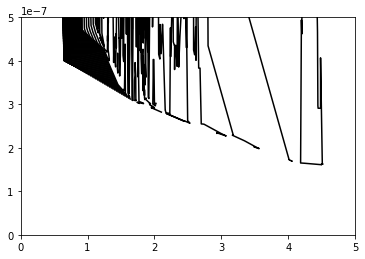

In [89]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt


x=megrid[:,0]
y=megrid[:,1]

# z=100*lim
# z=np.random.random(3470)
plt.tricontour(x, y, z, levels=100, colors='k')
# plt.tricontourf(x, y, z)

# plt.yscale("log")
plt.xlim([0,5])
plt.ylim([0,5e-7])

In [68]:
mcgrid[:,0].shape

(3470,)

In [69]:
mcgrid[:,1].shape

(3470,)